# Reproduzindo métricas de Centralidade Temporal (Costa et al., 2015)

Este notebook demonstra o cálculo aproximado das métricas **Time-Constrained Coverage (TCC)** e **Cover Time (CT)**
utilizando o dataset **MOSAR**, conforme descrito em *Costa et al., 2015 - "Time Centrality in Dynamic Complex Networks"*.

O código a seguir foi adaptado em Python 3 com base no script original `CreateAdjMatrix.py` do dataset,
implementando a simulação de difusão temporal conforme o artigo.


In [ ]:
# ------------------------------------------------------------------------------
# @title Importação das bibliotecas
# ------------------------------------------------------------------------------

import os, glob, math, random, time, statistics, pickle, json
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


### Parâmetros

In [ ]:
# @title Parâmetros de execução
# ------------------------------------------------------------------------------

slot_size = 30              # instantes de tempo
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
samples_per_slot = 20       # seeds por instante

In [ ]:
# @title Parâmetros da rede MOSAR
# ------------------------------------------------------------------------------

MOSAR_slots_to_use = 33000  # conforme o paper para MOSAR (primeiros 33.000 instantes)
use_full = False            # se True, tenta usar todos os start slots (muito custoso)
sample_start_mosar = 20     # número de instantes de início amostrados quando use_full=False

In [ ]:
# @title Parâmetros da rede aleatória
# ------------------------------------------------------------------------------
n_nodes = 160
T_random = 800
T_random_eval = 660        # primeiros 660 instantes para avaliação (como no paper)
sample_start_random = 200  # número de instantes de início amostrados (para execução rápida)


In [ ]:
# @title Parâmetros para calcular o *Cover Time*
# ------------------------------------------------------------------------------

taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
max_CT_steps = 40320  # limite superior de passos (nº de slots total no dataset)

### Importação dos arquivos (Drive)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Caminho para a pasta de dados (ajuste conforme seu ambiente)
# data_dir = "MAG_MOSAR/DATA"
data_dir = '/content/drive/MyDrive/Pós-graduação/Doutorado/Disciplinas/2025 3 - Tópicos Avançados em inteligência Computacional/Códigos/MAG_MOSAR/DATA'

# Listar arquivos de nós (cada .cnt corresponde a um indivíduo)
files = glob.glob(os.path.join(data_dir, "*.cnt"))
print(f"Arquivos encontrados: {len(files)}")


Arquivos encontrados: 160


## Criação da base de dados

### Rede MOSAR

In [ ]:
# @title Leitura dos eventos e contagem de nós
# ------------------------------------------------------------------------------

# Ler eventos (timestamp, origem, destino) de todos os arquivos .cnt
events = []
nodes_set = set()
for fpath in files:
    with open(fpath, 'rb') as fh:
        for ln in fh:
            try:
                s = ln.decode('latin1').strip()
            except:
                continue
            if not s:
                continue
            parts = s.split('\t')
            if len(parts) < 3:
                continue
            ts = int(parts[0])
            a = parts[1].strip()
            b = parts[2].strip()
            events.append((ts, a, b))
            nodes_set.add(a)
            nodes_set.add(b)

print(f"Eventos lidos: {len(events)} | Nós: {len(nodes_set)}")

Eventos lidos: 209705 | Nós: 160


In [ ]:
# @title Normalização dos instantes de tempo
# ------------------------------------------------------------------------------

# Normalizar timestamps em slots de 30s (parâmetro do código)
timestamps = sorted({e[0] for e in events})
min_ts = min(timestamps)
max_ts = max(timestamps)
num_slots = (max_ts - min_ts)//slot_size + 1

print(f"Período: {min_ts} - {max_ts} | Total de slots (30s): {num_slots}")

Período: 1248472800 - 1249682370 | Total de slots (30s): 40320


In [ ]:
# @title Construção dos *snapshots*
# ------------------------------------------------------------------------------

# Construir snapshots (adjacência temporal)
MAX_SLOTS = MOSAR_slots_to_use  # pode ajustar para o total completo (~40k)
adj = [defaultdict(set) for _ in range(MAX_SLOTS)]

for ts, a, b in events:
    slot = (ts - min_ts)//slot_size
    if slot < MAX_SLOTS:
        adj[slot][a].add(b)
        adj[slot][b].add(a)

nodes = sorted(nodes_set)
num_nodes = len(nodes)

print(f"Número de slots usado: {MAX_SLOTS} | Slots com arestas: {sum(1 for s in adj if s)}")
# print(f"Nós: {num_nodes} | Slots com arestas: {sum(1 for s in adj if s)}")

Número de slots usado: 33000 | Slots com arestas: 29891


### Rede aleatória

In [ ]:
# @title Construção das arestas
# ------------------------------------------------------------------------------

# Probabilidade de aresta conforme o artigo
p = 0.01 * (math.log(n_nodes) / n_nodes)
print(f"Probabilidade p = {p:.6f} para n = {n_nodes}")

Probabilidade p = 0.000317 para n = 160


In [ ]:
# @title Construção dos *snapshots*
# ------------------------------------------------------------------------------

# --- Gerar TVG aleatória (R) ---
# Cada snapshot é um grafo Erdős–Rényi G(n,p) independente

def generate_random_snapshot(n, p):
    adj = defaultdict(set)
    for i in range(n):
        for j in range(i+1, n):
            if np.random.rand() < p:
                adj[i].add(j)
                adj[j].add(i)
    return adj

adj_random = [generate_random_snapshot(n_nodes, p) for _ in range(T_random)]
print(f"Gerado TVG aleatório com {len(adj_random)} snapshots.")

Gerado TVG aleatório com 800 snapshots.


## Cálculo do CT

Este notebook adiciona uma seção para calcular a **função de distribuição cumulativa (CDF)** do **Cover Time (CT)** para vários valores de τ = {0.1, 0.2, ..., 0.6}, seguindo a descrição do artigo.

In [ ]:
# @title Função de cálculo do *Cover Time*
# ------------------------------------------------------------------------------

# Função otimizada para calcular CT (retorna número de passos até atingir 'target' ou np.inf)
def cover_time_from_seed(start_node, start_slot, target_count, adj, max_steps):
    infected = set([start_node])
    if len(infected) >= target_count:
        return 0
    for step in range(max_steps):
        slot = start_slot + step
        if slot >= len(adj):
            return np.inf
        slot_adj = adj[slot]
        new_infected = set(infected)
        for u in infected:
            if u in slot_adj:
                new_infected |= slot_adj[u]
        if len(new_infected) >= target_count:
            return step+1
        infected = new_infected
    return np.inf

# Função para gerar a amostra de start slots conforme o modo
def get_start_slots_list(use_full, MOSAR_slots_to_use, sample_start_slots):
    if use_full:
        return list(range(0, MOSAR_slots_to_use))
    else:
        # amostra uniforme ao longo dos primeiros MOSAR_slots_to_use instantes
        if sample_start_slots >= MOSAR_slots_to_use:
            return list(range(0, MOSAR_slots_to_use))
        return sorted(np.random.choice(range(0, MOSAR_slots_to_use), size=sample_start_slots, replace=False))

In [ ]:
# @title Rede MOSAR
# ------------------------------------------------------------------------------

# --- Computar CTs para cada τ ---
start_slots = get_start_slots_list(use_full, MOSAR_slots_to_use, sample_start_mosar)
print(f'Nº de slots iniciais considerado: {len(start_slots)} (use_full={use_full})')

# Para cada tau, coletar uma lista de CTs (em número de slots) sobre todas as amostras (start_slot x seed)
ct_mosar = {tau: [] for tau in taus}

start_time = time.time()
for idx, s in enumerate(start_slots):
    # escolher seeds: amostragem de nodes para cada slot (pode usar todos os nodes se samples_per_slot == len(nodes))
    if samples_per_slot >= len(nodes):
        seeds = nodes
    else:
        seeds = random.sample(nodes, samples_per_slot)
    for seed in seeds:
        # Para cada tau, computar target e CT
        for tau in taus:
            target = math.ceil(tau * num_nodes)
            ct = cover_time_from_seed(seed, s, target, adj, max_CT_steps)
            # guardar (ct em slots). Para tratamento da CDF, mantemos np.inf para não-alcancados
            ct_mosar[tau].append(ct)
    if (idx+1) % 200 == 0:
        elapsed = time.time() - start_time
        print(f'{idx+1}/{len(start_slots)} processados (~{elapsed:.1f}s decorridos)')
end_time = time.time()
print(f'Cálculo de CT (rede MOSAR) concluído em {end_time - start_time:.1f}s')

Nº de slots iniciais considerado: 20 (use_full=False)
Cálculo de CT (rede MOSAR) concluído em 17.6s


In [ ]:
# @title Rede aleatória
# ------------------------------------------------------------------------------

# --- Calcular CT para cada τ na TVG aleatória ---
max_steps = T_random

start_slots = sorted(np.random.choice(range(T_random_eval), sample_start_random, replace=False))
ct_random = {tau: [] for tau in taus}

t0 = time.time()
for idx, s in enumerate(start_slots):
    seeds = random.sample(range(n_nodes), samples_per_slot)
    for seed in seeds:
        for tau in taus:
            target = math.ceil(tau * n_nodes)
            ct = cover_time_from_seed(seed, s, target, adj_random, max_steps)
            ct_random[tau].append(ct)
    if (idx+1) % 50 == 0:
        print(f"{idx+1}/{len(start_slots)} slots processados...")
t1 = time.time()
print(f"Cálculo de CT (rede aleatória) concluído em {t1 - t0:.1f}s")

50/200 slots processados...
100/200 slots processados...
150/200 slots processados...
200/200 slots processados...
Cálculo de CT (rede aleatória) concluído em 5.0s


## Visualização dos resultados

Esta seção plota as curvas de **Time-Constrained Coverage (TCC)** e **Cover Time (CT)**
em função dos instantes de tempo (slots) — reproduzindo o tipo de figura apresentado no artigo de Costa et al. (2015).



### *Cover Time*

In [ ]:
# @title Função para construir os gráficos
# ------------------------------------------------------------------------------

def plot_cdf_sets(ct_data, label_prefix):
    for tau in taus:
        data = np.array(ct_data[tau])
        finite_data = data[np.isfinite(data)]
        if len(finite_data) == 0:
            continue
        sorted_vals = np.sort(finite_data)
        cdf = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)
        plt.plot(sorted_vals, cdf, lw=1.8, label=f"τ={tau}")
        # plt.plot(sorted_vals, cdf, label=f'tau={tau} (finite={len(sorted_vals)}/{len(data)})')

        plt.xlabel("Cover Time (nº de slots)")
        plt.ylabel("CDF")
        plt.title(f"CDF do Cover Time (CT) — {label_prefix}")
        plt.grid(True, alpha=0.3)
        plt.legend()


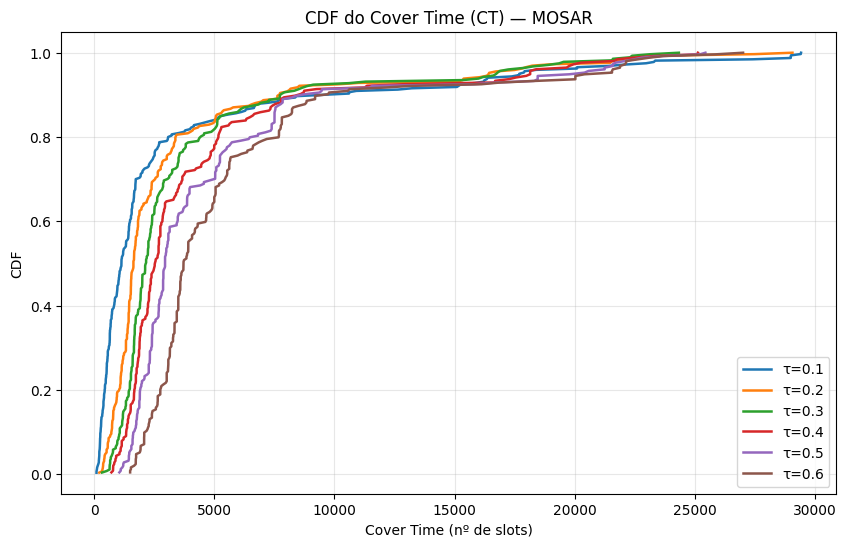

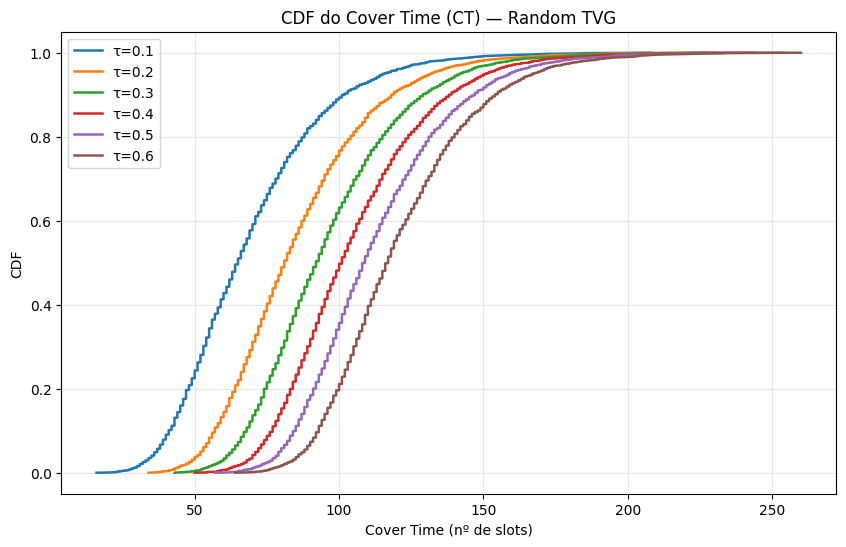

In [ ]:
# @title Resultados dos gráficos
# ------------------------------------------------------------------------------

# Primeiro gráfico: CDF do MOSAR
plt.figure(figsize=(10,6))
plot_cdf_sets(ct_mosar, "MOSAR")
plt.show()

print("\n")

# Segundo gráfico: CDF da TVG Aleatória
plt.figure(figsize=(10,6))
plot_cdf_sets(ct_random, "Random TVG")
plt.show()